In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from PIL import Image
from os.path import splitext


En utilisant d’abord la bibliothèque du système d’exploitation, je vais télécharger les images des paires de paysages urbains.

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
path='data'
def images_upload(path):
    images=[]
    for root,subfolders,files in os.walk(path):
        for file in tqdm(files):
            filename=root+os.sep+file
            if filename.endswith('jpg') or filename.endwith('png'):
                images.append(filename)
    return images
images=images_upload(path)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 2975/2975 [00:00<00:00, 800080.43it/s]


In [ ]:
def convert_image_rgb(data):
    imgs=[]
    for i in tqdm(data):
        img = cv2.imread(i,cv2.COLOR_BGR2RGB)
        del i
        imgs.append(img)
    return imgs
img=convert_image_rgb(images)

100%|██████████| 6950/6950 [01:15<00:00, 91.50it/s] 


Regardons l'une des images. On peut voir que l’image contient à la fois l’image réelle et le masque, la prochaine tâche consistera donc à les distinguer. Randmoly a sélectionné l'image suivante

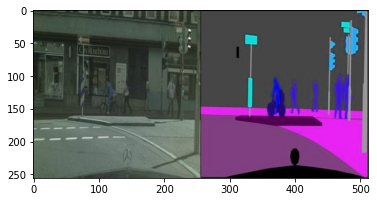

In [ ]:
plt.imshow(img[np.random.randint(0,len(img))]);

<p style="padding: 10px;color:black;font-size:120%;font-family: Times New Roman, Times, serif;">Because the image shape is 512*256, it should be divided into two groups, real images and mask images, at 256 pixels on the x axis.</p>

In [ ]:
def split_input_mask(data):
    inputs=[]
    mask=[]
    for i in data:
        a=i[:,:256]
        inputs.append(a)
        b=i[:,256:]
        mask.append(b)
    return inputs,mask
inputs,mask=split_input_mask(img)

<p style="padding: 10px;color:black;font-size:120%;font-family: Times New Roman, Times, serif;">In this section, I'll show a few images of the real images as well as a few images of the mask images after they've been separated.</p>

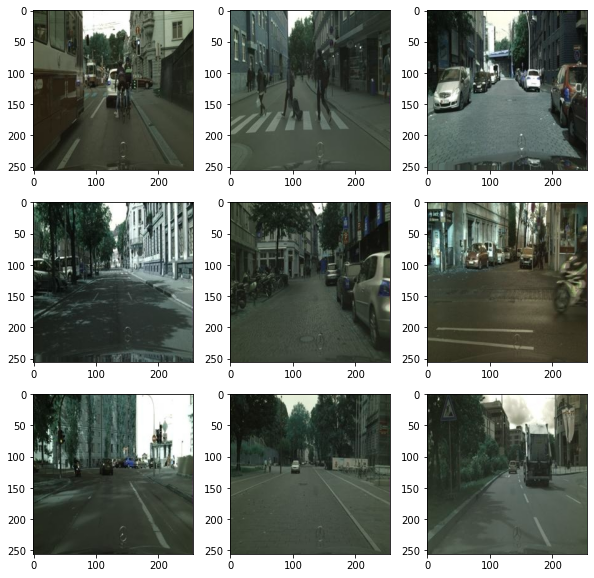

In [ ]:
def show_images(data):
    plt.figure(figsize=(10,10))
    for i in range(9):
        idx=np.random.randint(0,len(data))
        plt.subplot(3,3,i+1)
        img=data[idx]
        plt.imshow(img)
show_images(inputs)

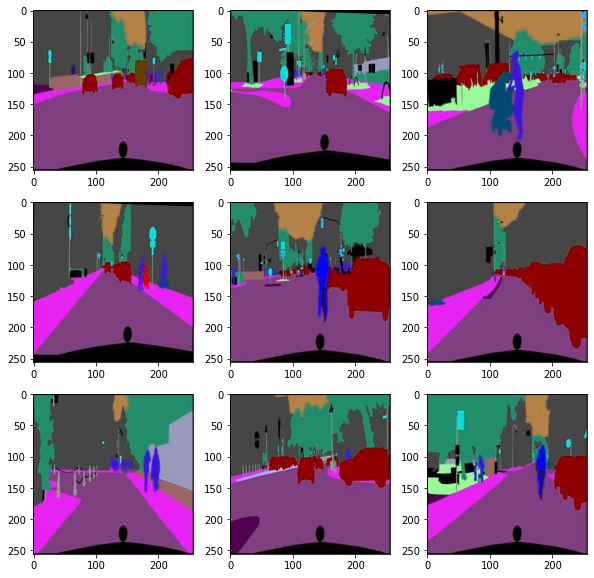

In [ ]:
show_images(mask)

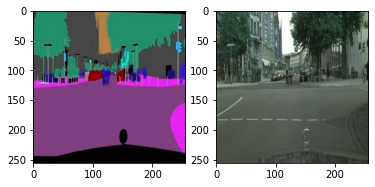

In [ ]:
def images_compare(inputs,mask):
    idx_new=np.random.randint(0,len(mask))
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(mask[idx_new])
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(inputs[idx_new],cmap='gray')
    plt.show()
images_compare(inputs,mask)

  Bien que chaque pixel de ces images soit étiqueté, il était néanmoins nécessaire de séparer les différentes couleurs par étiquettes. Les K-means seront utilisés pour classer ces étiquettes colorées en 10 groupes différents. Il s'agit d'un hyperparamètre. Les prochaines images étiquetées seront affichées, suivies d'un redimensionnement de l'image originale.

In [ ]:
def new_labels(mask):
    num_items = 1000
    color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
    num_classes = 10
    label_model = KMeans(n_clusters = num_classes)
    label_model.fit(color_array)
    labels=[]
    for i in tqdm(range(len(mask))):
        label_class = label_model.predict(mask[i].reshape(-1,3)).reshape(256,256)
        labels.append(label_class)
    return labels


In [ ]:
labels=new_labels(mask)
idx=np.random.randint(0,len(labels))
classes,freq=np.unique(labels[idx],return_counts=True)
print(f'number of classes :{len(classes)}')

100%|██████████| 6950/6950 [00:21<00:00, 316.95it/s]

number of classes :10


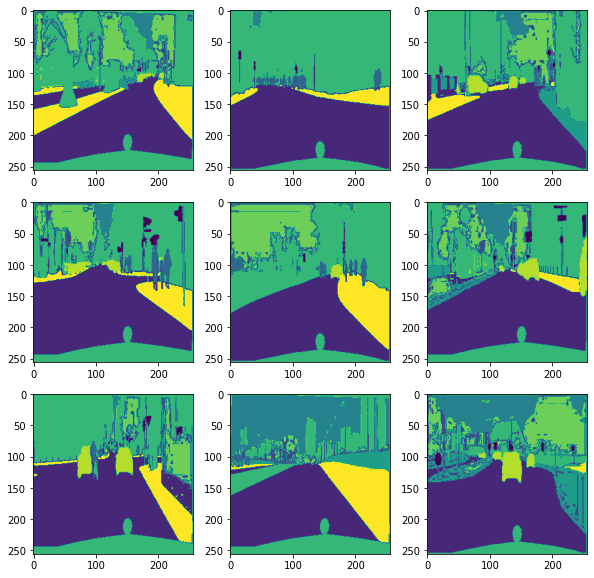

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
        plt.subplot(3,3,i+1)
        im=labels[i]
        plt.imshow(im)
# plt.imshow(a)

In [ ]:
def rescale(data):
    rescaled=[]
    for i in tqdm(data):
        img=tf.image.convert_image_dtype(i, tf.float32) #convertit images en un format spécifique (en virgule flottante )
        del i
        rescaled.append(img)
    return rescaled
    #. Cela peut être utile dans le traitement d'images pour s'assurer que les valeurs des pixels sont dans la plage appropriée.

In [ ]:
rescaled_input=rescale(inputs)


100%|██████████| 6950/6950 [00:05<00:00, 1293.32it/s]


 Ici, j'utilise UNet puisque la position de l'objet est cruciale pour cette tâche. La carte de caractéristiques est suréchantillonnée à la taille de l'image d'entrée d'origine à l'aide d'une couche de convolution transposée qui préserve les informations spatiales. Il inclut également des connexions ignorées, qui permettent de conserver les informations qui seraient autrement perdues lors du codage. Ce modèle est une sorte de mini-VGG.

In [ ]:
def build_model(inputsize=(256,256,3),classes=None):
  #Crée un espace réservé (placeholder) d'entrée pour le modèle.
    inputs = tf.keras.Input(shape=(inputsize)) #

    conv = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv1')(inputs) # Définit une couche de convolution en 2D.
    x=tfl.BatchNormalization()(conv) ##Ajoute une normalisation par lots au modèle.
    x=tfl.LeakyReLU()(x)
    x1 = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv2')(x)
    x=tfl.BatchNormalization()(x1)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(x)

    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv3')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x2 = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv4')(x)
    x=tfl.BatchNormalization()(x2)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), name='MaxPool2')(x)

    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv5')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x3 = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv6')(x)
    x=tfl.BatchNormalization()(x3)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool3')(x)


    x = tfl.Conv2D(256, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv7')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(256, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv8')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    #=============================================
    x = tfl.Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x3], axis=3)

    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv9')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv10')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x2], axis=3)

    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv11')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv12')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x1], axis=3)

    x = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv25')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv26')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    outputs = tfl.Conv2D(classes, (1, 1), padding="same", activation='softmax', name='Outputs')(x)
    final_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    final_model.summary()
    return final_model

In [ ]:
mymodel=build_model(classes=10)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

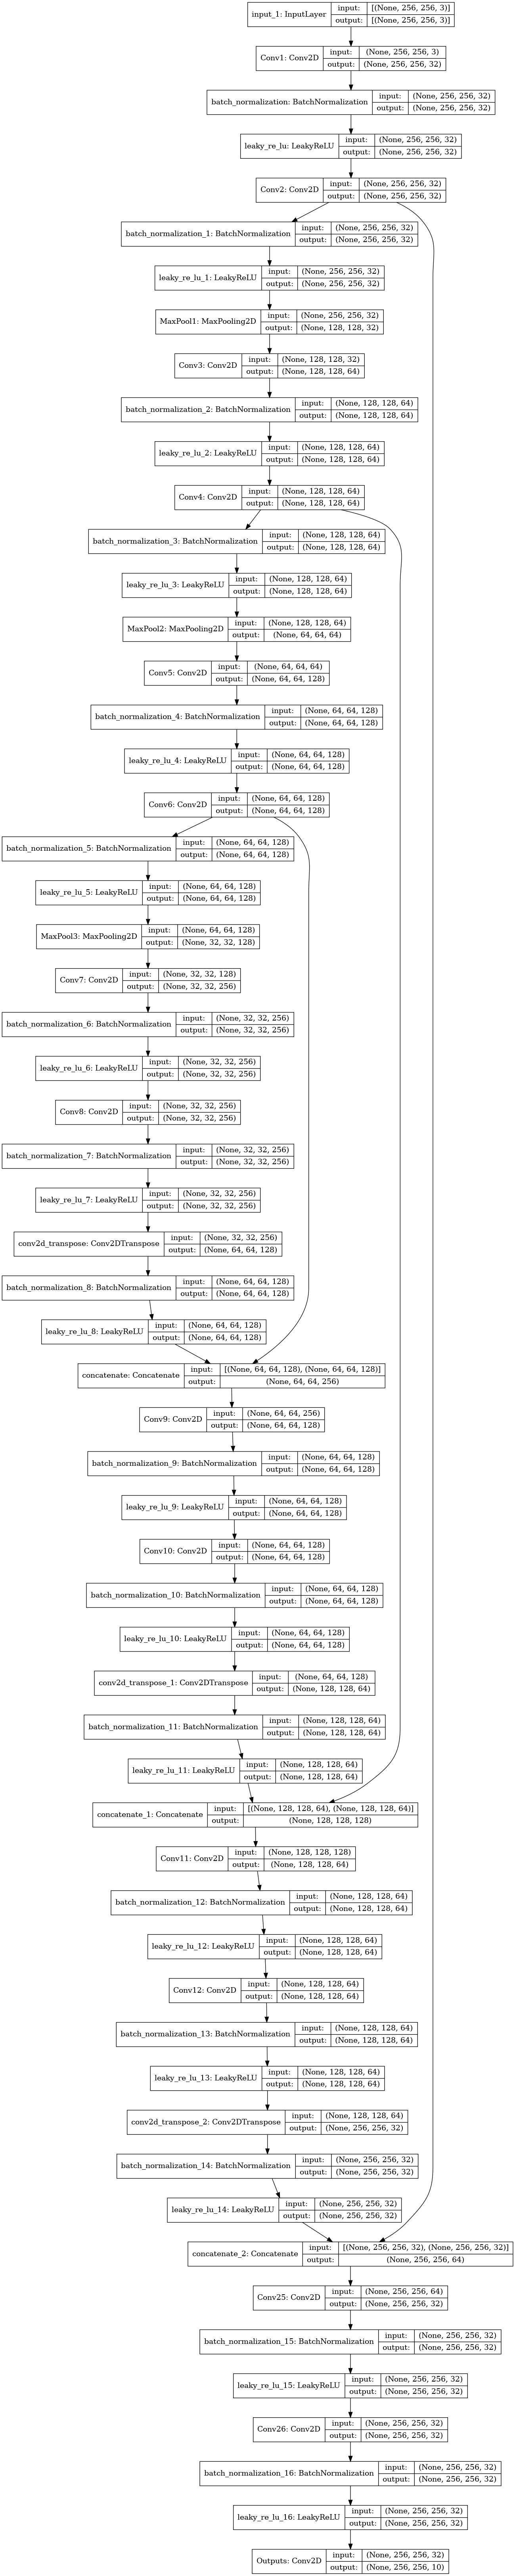

In [ ]:
img_file = './model_arch.png'

tf.keras.utils.plot_model(mymodel, to_file=img_file, show_shapes=True, show_layer_names=True)

In [ ]:
del inputs

 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:300%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b>Training the model</b>

<p style="padding: 10px;color:black;font-size:40%;font-family: Times New Roman, Times, serif;"> The data is divided into train and test segments, with each segment accounting for 80% and 20% of the total. To prevent RAM memory from crashing, I'm using 1300 images. Because the model's output employs 'softmax' activation layer, the loss function is sparse categorical crossentropy. Next, I'm going to use argmax to return the index with the highest value, and then I'm going to make some predictions for the test.</p>

In [ ]:
def split_data(x,y,test_size=0.2):
    x1=np.array(x)
    del x
    y1=np.array(y)
    del y
    x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=test_size)
    return  x_train, x_test, y_train, y_test

In [ ]:
 x_train, x_test, y_train, y_test=split_data(rescaled_input[:1300],labels[:1300],test_size=0.2)



In [ ]:
def callbacks(patience=5):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('seg_model.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
    early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=patience)
    callbacks_list=[checkpoint, early]
    return callbacks_list
#cette fonction vous permet de définir une liste de rappels pour l'entraînement de modèle

In [ ]:
mymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=['acc'])
hist=mymodel.fit(x_train,y_train,batch_size=16,epochs=200,callbacks=callbacks())

Epoch 1/200
65/65 [==============================] - 21s 172ms/step - loss: 1.1778 - acc: 0.6275

Epoch 00001: loss improved from inf to 1.17780, saving model to seg_model.h5
Epoch 2/200
65/65 [==============================] - 11s 172ms/step - loss: 0.9487 - acc: 0.6923

Epoch 00002: loss improved from 1.17780 to 0.94870, saving model to seg_model.h5
Epoch 3/200
65/65 [==============================] - 11s 172ms/step - loss: 0.8624 - acc: 0.7145

Epoch 00003: loss improved from 0.94870 to 0.86238, saving model to seg_model.h5
Epoch 4/200
65/65 [==============================] - 11s 172ms/step - loss: 0.7906 - acc: 0.7363

Epoch 00004: loss improved from 0.86238 to 0.79062, saving model to seg_model.h5
Epoch 5/200
65/65 [==============================] - 11s 173ms/step - loss: 0.7695 - acc: 0.7434

Epoch 00005: loss improved from 0.79062 to 0.76954, saving model to seg_model.h5
Epoch 6/200
65/65 [==============================] - 11s 172ms/step - loss: 0.7336 - acc: 0.7538

Epoch 00006

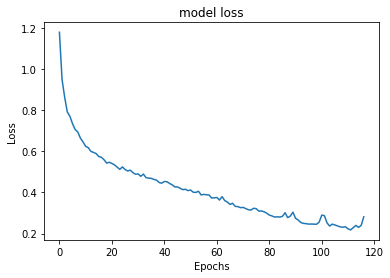

In [ ]:
plt.plot(hist.history['loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

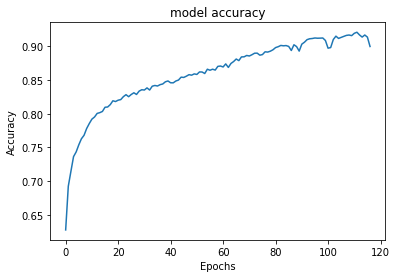

In [ ]:
plt.plot(hist.history["acc"])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [ ]:
pred=mymodel.predict(x_test)
y_pred=tf.argmax(pred,axis=-1)

In [ ]:

def show_predications(x_test,y_test,y_pred):
    idx=np.random.randint(0,len(y_pred))
    fig, axes = plt.subplots(1,3,figsize=(10,10))
    axes[0].imshow(x_test[idx])
    axes[0].set_title("original")
    axes[1].imshow(y_test[idx])
    axes[1].set_title("mask")
    axes[2].imshow(y_pred[idx])
    axes[2].set_title("predicated")



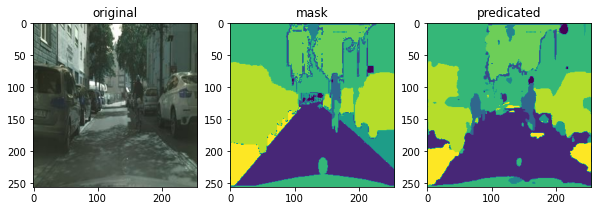

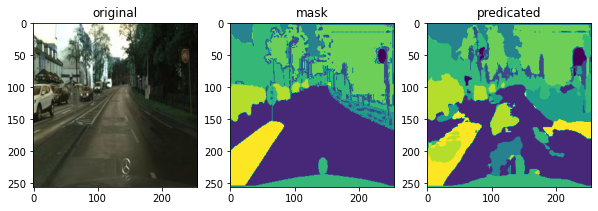

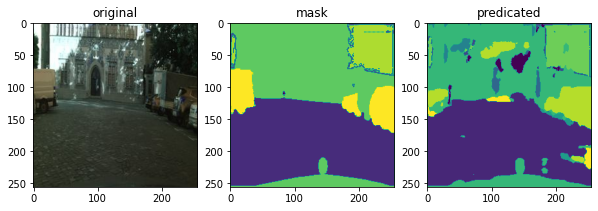

In [ ]:
for i in range(3):
    show_predications(x_test,y_test,y_pred)

Même si les résultats ne sont pas étonnants, ils ne sont pas si mauvais. Davantage de couches, ainsi que des augmentations et différents regroupements de classes, sont nécessaires pour obtenir des résultats encore meilleurs.



